In [1]:
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
SAVE_PATH = "./figures"

In [3]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve(L, a, b, metric):

    try:
        warnings.simplefilter("error")
        if not check_feasibility(L, a, b):
            raise ValueError("infeasible")
        
        x = cp.Variable(len(a))

        if (metric == "sw") or (metric == 0):
            objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        elif (metric == "pf") or (metric == 1):
            objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a, x) + b - L)))
        elif (metric == "mm") or (metric == float("inf")):
            objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
        else:
            y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
            objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))

        constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver="CLARABEL")

        user_surplus = -0.5*a*x.value**2 + (b - L)*x.value
        surplus = np.sum(user_surplus)

        return problem.value, x.value, user_surplus, surplus, "success"
    
    except (Warning, cp.SolverError, TypeError, ValueError) as e:
        return np.nan, np.full(len(a), np.nan), np.full(len(a), np.nan), np.nan, str(e)


def solve_wrapper(params):
    
    L = params["L"]
    seed = params["seed"]
    n_users = params["n_users"]

    np.random.seed(seed)
    a = 1*np.random.rand(n_users) + 1
    b = (a + 1)*10 + 10*np.random.rand(n_users) + 1
        
    sw_val, sw_sol, sw_user_surplus, sw_surplus, sw_message = solve(L, a, b, "sw")
    pf_val, pf_sol, pf_user_surplus, pf_surplus, pf_message = solve(L, a, b, "pf")
    mm_val, mm_sol, mm_user_surplus, mm_surplus, mm_message = solve(L, a, b, "mm")
    alpha0_val, alpha0_sol, alpha0_user_surplus, alpha0_surplus, alpha0_message = solve(L, a, b, 0.5)
    alpha1_val, alpha1_sol, alpha1_user_surplus, alpha1_surplus, alpha1_message = solve(L, a, b, 1.5)
    alpha2_val, alpha2_sol, alpha2_user_surplus, alpha2_surplus, alpha2_message = solve(L, a, b, 2.0)        
    messages = dict(sw=sw_message, pf=pf_message, mm=mm_message, alpha0=alpha0_message, alpha1=alpha1_message, alpha2=alpha2_message)
        
    return dict(
        experiment_id=f"{n_users}-{seed}", n_users=n_users, seed=seed, messages=messages, L=L,
        sw_val=sw_val, sw_sol=sw_sol, sw_surplus=sw_surplus, sw_min_surplus=np.min(sw_user_surplus),
        pf_val=pf_val, pf_sol=pf_sol, pf_surplus=pf_surplus, pf_min_surplus=np.min(pf_user_surplus),
        mm_val=mm_val, mm_sol=mm_sol, mm_surplus=mm_surplus, mm_min_surplus=np.min(mm_user_surplus),
        alpha0_val=alpha0_val, alpha0_sol=alpha0_sol, alpha0_surplus=alpha0_surplus, alpha0_min_surplus=np.min(alpha0_user_surplus),
        alpha1_val=alpha1_val, alpha1_sol=alpha1_sol, alpha1_surplus=alpha1_surplus, alpha1_min_surplus=np.min(alpha1_user_surplus),
        alpha2_val=alpha2_val, alpha2_sol=alpha2_sol, alpha2_surplus=alpha2_surplus, alpha2_min_surplus=np.min(alpha2_user_surplus),        
    )

In [4]:
%%time
params_list = [
    dict(L=L, n_users=n_users, seed=seed)
    for L in np.arange(0.1, 100, 0.1)
    for n_users in np.append(np.arange(1, 8), 2**np.arange(3, 10))
    for seed in range(100)
]

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
results = pd.DataFrame(results)
pool.close()

CPU times: user 1min 20s, sys: 20.2 s, total: 1min 41s
Wall time: 19min 20s


In [5]:
%%time

select_cols = ["n_users", "sw_surplus", "pf_surplus", "mm_surplus", "alpha0_surplus", "alpha1_surplus", "alpha2_surplus"]
select_cols += ["sw_min_surplus", "pf_min_surplus", "mm_min_surplus", "alpha0_min_surplus", "alpha1_min_surplus", "alpha2_min_surplus"]
df = results.dropna().groupby("experiment_id")[select_cols].max().reset_index()

CPU times: user 1.28 s, sys: 1.05 ms, total: 1.28 s
Wall time: 1.31 s


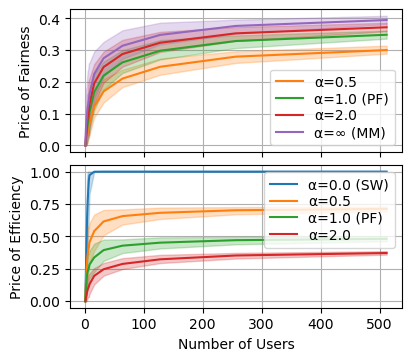

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3.5), constrained_layout=True)


# calculate price of fairness
df["α=1.0 (PF)"] = (df.sw_surplus - df.pf_surplus) / df.sw_surplus
df["α=∞ (MM)"] = (df.sw_surplus - df.mm_surplus) / df.sw_surplus
df["α=0.5"] = (df.sw_surplus - df.alpha0_surplus) / df.sw_surplus
df["α=1.5"] = (df.sw_surplus - df.alpha1_surplus) / df.sw_surplus
df["α=2.0"] = (df.sw_surplus - df.alpha2_surplus) / df.sw_surplus

select_cols = ["α=0.5", "α=1.0 (PF)", "α=2.0", "α=∞ (MM)", ]
df_mean = df.groupby("n_users")[select_cols].mean().reset_index()
df_05 = df.groupby("n_users")[select_cols].quantile(0.05).reset_index()
df_95 = df.groupby("n_users")[select_cols].quantile(0.95).reset_index()

for i, x in zip([1,2,3,4], select_cols):
    axs[0].plot(df_mean.n_users, df_mean[x], label=x, color=f"C{i}")
    axs[0].fill_between(df_mean.n_users, df_05[x], df_95[x], color=f"C{i}", alpha=0.25)
axs[0].set_ylabel("Price of Fairness")
axs[0].legend(loc=0, labelspacing=0.2)
axs[0].set_xticks(range(0, 600, 100), [])
axs[0].set_axisbelow(True)
axs[0].grid(zorder=0)


# calculate price of efficiency
df["α=0.0 (SW)"] = (df.mm_min_surplus - df.sw_min_surplus) / df.mm_min_surplus
df["α=1.0 (PF)"] = (df.mm_min_surplus - df.pf_min_surplus) / df.mm_min_surplus
df["α=0.5"] = (df.mm_min_surplus - df.alpha0_min_surplus) / df.mm_min_surplus
df["α=1.5"] = (df.mm_min_surplus - df.alpha1_min_surplus) / df.mm_min_surplus
df["α=3.0"] = (df.mm_min_surplus - df.alpha2_min_surplus) / df.mm_min_surplus

select_cols = ["α=0.0 (SW)", "α=0.5", "α=1.0 (PF)", "α=2.0"]
df_mean = df.groupby("n_users")[select_cols].mean().reset_index()
df_05 = df.groupby("n_users")[select_cols].quantile(0.05).reset_index()
df_95 = df.groupby("n_users")[select_cols].quantile(0.95).reset_index()

for i, x in zip([0,1,2,3,5], select_cols):
    axs[1].plot(df_mean.n_users, df_mean[x], label=x, color=f"C{i}")
    axs[1].fill_between(df_mean.n_users, df_05[x], df_95[x], color=f"C{i}", alpha=0.25)
axs[1].set_ylabel("Price of Efficiency")
axs[1].set_xlabel("Number of Users")
axs[1].legend(loc=1, labelspacing=0.2)
axs[1].set_axisbelow(True)
axs[1].grid(zorder=0)

plt.savefig(f"{SAVE_PATH}/pof-poe-vs-n_users-small.png", dpi=300)
plt.show()